In [1]:
#import all necessary packages
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
from pylab import plot, show
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.discrete.discrete_model as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
#Reading the csv files
df1 = pd.read_csv('./bank-additional/bank-additional-full.csv',sep=';')
df2 = pd.read_csv('./bank-additional/bank-additional.csv',sep=';')
data = pd.concat([df1,df2])
data1 = data


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45307 entries, 0 to 4118
Data columns (total 21 columns):
age               45307 non-null int64
job               45307 non-null object
marital           45307 non-null object
education         45307 non-null object
default           45307 non-null object
housing           45307 non-null object
loan              45307 non-null object
contact           45307 non-null object
month             45307 non-null object
day_of_week       45307 non-null object
duration          45307 non-null int64
campaign          45307 non-null int64
pdays             45307 non-null int64
previous          45307 non-null int64
poutcome          45307 non-null object
emp.var.rate      45307 non-null float64
cons.price.idx    45307 non-null float64
cons.conf.idx     45307 non-null float64
euribor3m         45307 non-null float64
nr.employed       45307 non-null float64
y                 45307 non-null object
dtypes: float64(5), int64(5), object(11)
memory usag

In [4]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,45307.000000,45307.000000,45307.000000,45307.000000,45307.000000,45307.000000,45307.000000,45307.000000,45307.000000,45307.000000
mean,40.032203,258.148917,2.564835,962.288785,0.174543,0.082166,93.576032,-40.502282,3.621297,5166.985525
std,10.411407,258.864200,2.752261,187.370863,0.499364,1.570231,0.578881,4.625101,1.734350,72.380791
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### We see that the column 'duration' seems skewed.  Also the range of 'nr.employed' is quite off scales for other columns. 

In [5]:
y_yes = data[data['y']=='yes']['y'].value_counts().sum()
y_no = data[data['y']=='no']['y'].value_counts().sum()
yes_pct = y_yes /(y_yes + y_no)
print(yes_pct)

0.11236674244597965


### We can see from calculation that the percentage of making deposits is about 11.2% of all subjects. The goal of this project is to predict the chance of people making deposit and the dataset makes imbalanced in term of this goal. Therefore it is feasible to either reduce the portion of non-making deposits or increase the portion of making depostis.

In [6]:
data_dmy = pd.get_dummies(data, columns =['job', 'marital', 'education','default', 'housing', 'loan','contact','month', 'day_of_week','poutcome'],drop_first=True)

data_dmy.loc[data_dmy.y == 'yes','y'] = 1
data_dmy.loc[data_dmy.y == 'no','y'] = 0
data_vars = data_dmy.columns.values.tolist()
data_vars


['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'default_unknown',
 'default_yes',
 'housing_unknown',
 'housing_yes',
 'loan_unknown',
 'loan_yes',
 'contact_telephone',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'day_of_week_wed',
 'poutcome_nonexistent',
 'poutcome_success']

In [7]:
#final_data_vars = data.columns.values.tolist()

y = ['y']
X = [i for i in data_vars if i not in y]

## Logistic Regression:

In [9]:
# Setup the hyperparameter grid
c_space = np.logspace(-50, 8, 50)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
#logreg = LogisticRegression(random_state=0, class_weight='balanced')
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=10)

# Fit it to the data
logreg_cv.fit(data_dmy[X], data_dmy['y'])

# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'C': 4.094915062380453e-08}
Best score is 0.9014942503365926


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data_dmy[X],data_dmy['y'], test_size=0.1, random_state=0)
#
LogReg = LogisticRegression(fit_intercept = False, C = 4.094915062380453e-08,random_state=0)

LogReg.fit(X_train.astype(float), y_train.astype(float))
score = LogReg.score(X_train.astype(float), y_train.astype(float))
print('Accuracy of logistic regression classifier on training set: {:.2f}\n'.format(score))

y_pred = LogReg.predict(X_test)
print('Accuracy of logistic regression classifier on testing set: {:.2f}\n'.format(LogReg.score(X_test, y_test)))

print(LogReg.coef_)
#print(np.std(X_train)*LogReg.coef_)

Accuracy of logistic regression classifier on training set: 0.90

Accuracy of logistic regression classifier on testing set: 0.91

[[ 2.00852449e-04  3.54470818e-03 -5.20312316e-05 -2.71396705e-03
   1.89132902e-05 -1.81064555e-04  1.30239372e-04  2.48725990e-05
  -1.93916297e-04 -1.53235736e-04 -1.27297128e-05 -1.25836820e-06
  -2.85055515e-07  1.58920615e-07  7.19437404e-06 -7.55776358e-07
  -3.57232715e-06  4.64527685e-06  4.65162096e-07  1.19792762e-06
  -1.96186723e-08 -7.70375887e-06  1.03754460e-05  2.31353281e-09
  -2.23107333e-06 -6.73318015e-06 -1.34789485e-06  9.27109981e-08
   7.10093503e-07  1.11738410e-05  1.77423363e-06 -1.49867556e-05
  -5.17268623e-09 -2.12016352e-08  3.46477678e-06 -2.12016352e-08
  -1.05877242e-06 -2.51951527e-05  6.43913802e-07  1.90895828e-06
  -5.91421919e-06  8.55382743e-07  7.48894646e-06 -2.10672668e-05
  -1.57529801e-06  6.80088142e-06  4.87622601e-06 -1.74700423e-06
   1.64533440e-06  1.36824173e-06  4.96350269e-07 -9.69998277e-06
   4.762431

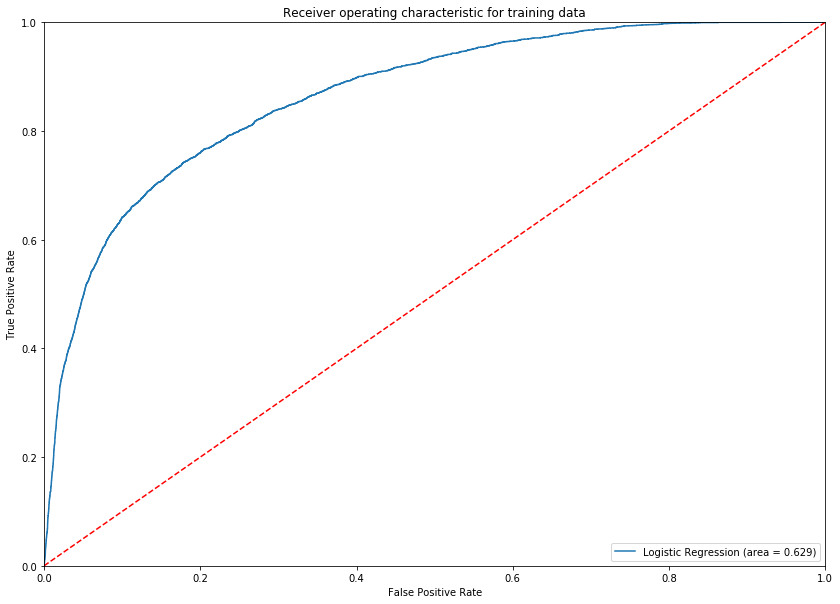

In [12]:
logit_roc_auc = roc_auc_score(y_train, LogReg.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, LogReg.predict_proba(X_train)[:,1])
fig = plt.figure(figsize=(14, 10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for training data')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

In [13]:
logit_model = sm.Logit(y_train.astype(float),X_train.astype(float))
result = logit_model.fit()
print(result.summary2())

         Current function value: 0.207344
         Iterations: 35
                                   Results: Logit
Model:                      Logit                  No. Iterations:         35.0000   
Dependent Variable:         y                      Pseudo R-squared:       0.411     
Date:                       2018-06-05 22:45       AIC:                    17013.2814
No. Observations:           40776                  BIC:                    17461.3056
Df Model:                   51                     Log-Likelihood:         -8454.6   
Df Residuals:               40724                  LL-Null:                -14355.   
Converged:                  0.0000                 Scale:                  1.0000    
-------------------------------------------------------------------------------------
                               Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-------------------------------------------------------------------------------------
age                     

C:\Users\VT\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\VT\Anaconda3\lib\site-packages\statsmodels\base\model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
C:\Users\VT\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\VT\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\VT\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [14]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print('The confusion matrix is :\n',confusion_matrix)
print(classification_report(y_test, y_pred))

The confusion matrix is :
 [[3973   61]
 [ 355  142]]
             precision    recall  f1-score   support

          0       0.92      0.98      0.95      4034
          1       0.70      0.29      0.41       497

avg / total       0.89      0.91      0.89      4531



## Oversampling imbalanced data

In [15]:
data_dmy = pd.get_dummies(data1, columns =['job', 'marital', 'education','default', 'housing', 'loan','contact','month', 'day_of_week','poutcome'],drop_first=True)

data_dmy.loc[data_dmy.y == 'yes','y'] = 1
data_dmy.loc[data_dmy.y == 'no','y'] = 0
data_vars = data_dmy.columns.values.tolist()
print(data_vars)

y = ['y']
X = [i for i in data_vars if i not in y]

# Setup the hyperparameter grid
c_space = np.logspace(-50, 8, 50)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
#logreg = LogisticRegression(random_state=0, class_weight='balanced')
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=10)

# Fit it to the data
logreg_cv.fit(data_dmy[X], data_dmy['y'])

# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))


['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'default_unknown', 'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success']
Tuned Logistic Regression Parameters: {'C': 4.094915062380453e-08}
Best score is 0.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_dmy[X],data_dmy['y'], test_size=0.1, random_state=0)
sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)


C:\Users\VT\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [17]:
LogReg = LogisticRegression(fit_intercept = False, C = 1e5,random_state=0)

LogReg.fit(X_train_res.astype(float), y_train_res.astype(float))
score = LogReg.score(X_train_res.astype(float), y_train_res.astype(float))
print('Accuracy of logistic regression classifier on training set: {:.2f}\n'.format(score))

y_pred = LogReg.predict(X_test)
print('Accuracy of logistic regression classifier on testing set: {:.2f}\n'.format(LogReg.score(X_test, y_test)))

print(LogReg.coef_)
#print(np.std(X_train)*LogReg.coef_)

Accuracy of logistic regression classifier on training set: 0.88

Accuracy of logistic regression classifier on testing set: 0.86

[[ 9.50840652e-04  7.14094749e-03 -6.31324069e-02 -1.86461865e-03
  -1.52927354e-01 -1.22523483e+00  6.39356120e-01 -1.74930340e-02
   7.39653911e-01 -1.24897288e-02 -3.41953390e-01 -1.46401649e-01
  -2.21928335e-02 -1.73117261e-01  3.14551980e-01 -3.76546533e-01
  -2.93238458e-01  2.84424243e-01  1.84515931e-02  2.18208375e-01
   2.36412717e-02  1.80228473e-01  2.39415535e-01 -8.73774478e-03
   2.47602480e-02 -7.03827714e-02 -7.72350580e-02  4.65286976e-02
   8.00912547e-02  2.29491986e-01  2.83963906e-02 -4.15081638e-01
  -1.08474500e-03 -3.85402459e-02 -1.57775397e-02 -3.85402459e-02
  -9.78464354e-02 -2.25197314e-01  3.89381839e-01 -6.48392897e-02
   5.45903398e-02 -1.41667088e-01  1.70073816e+00 -1.19321138e+00
  -7.63798750e-01  5.69802158e-01 -2.00031279e-01 -9.26059712e-02
  -5.56101252e-02  1.47419239e-02  1.13383345e-01  4.43668911e-01
   2.221153

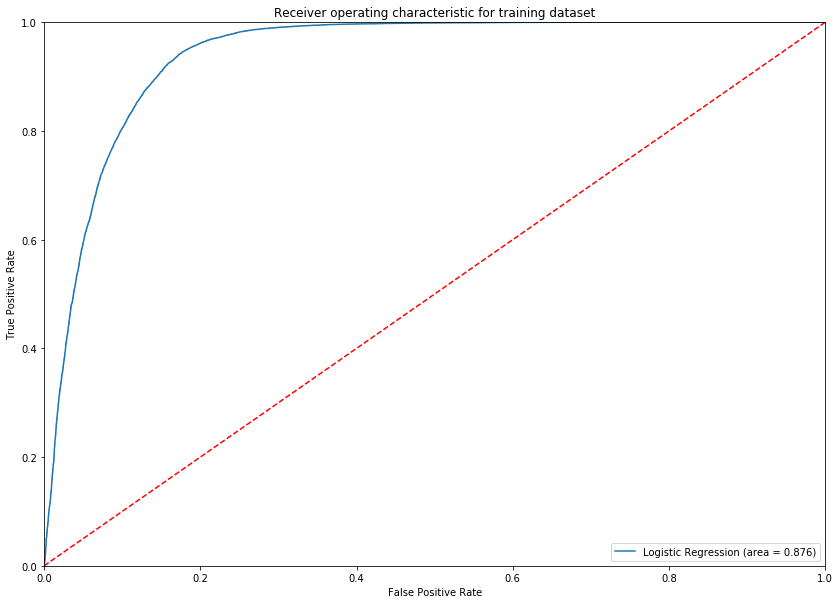

In [18]:
logit_roc_auc = roc_auc_score(y_train_res, LogReg.predict(X_train_res))
fpr, tpr, thresholds = roc_curve(y_train_res, LogReg.predict_proba(X_train_res)[:,1])
fig = plt.figure(figsize=(14, 10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for training dataset')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

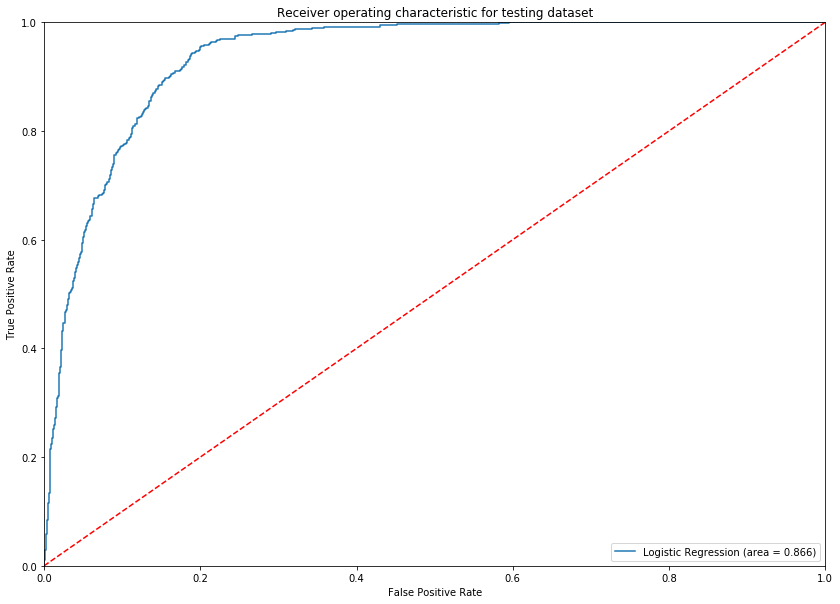

In [19]:
logit_roc_auc = roc_auc_score(y_test, LogReg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, LogReg.predict_proba(X_test)[:,1])
fig = plt.figure(figsize=(14, 10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for testing dataset')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')